In [34]:
import os
import json

In [82]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
%matplotlib inline

In [37]:
data_dir = '/content/data/Cotton Disease'
print(os.listdir(data_dir)[:10])

['train', 'test', 'val']


In [38]:
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['train', 'test', 'val']
['diseased cotton plant', 'fresh cotton plant', 'diseased cotton leaf', 'fresh cotton leaf']


In [39]:
diseases_cotton_leaf = os.listdir(data_dir + "/train/diseased cotton plant")
print('No. of training examples for diseased cotton leaf : ', len(diseases_cotton_leaf))
print(diseases_cotton_leaf[:5])

No. of training examples for diseased cotton leaf :  815
['dd (890)_iaip.jpg', 'dd (528)_iaip.jpg', 'dd (814)_iaip.jpg', 'dd (633)_iaip.jpg', 'dd (469)_iaip.jpg']


In [40]:
for i in classes:
  results = os.listdir(data_dir + "/train/" + i)
  print(f"Number of images in [i] = {len(results)}")

Number of images in [i] = 815
Number of images in [i] = 421
Number of images in [i] = 288
Number of images in [i] = 427


In [41]:
image_size = 32
batch_size = 64
stats = ((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))

In [42]:
# import torch
# from torchvision import datasets, transforms
# import os

# # Define the transformation without normalization

# transform = transforms.Compose([
#     transforms.Resize((32, 32)),  # Resize to 32x32 pixels
#     transforms.ToTensor()
# ])

# # Load your custom dataset using ImageFolder (train, test, val folders)
# train_dir = '/content/data/Cotton Disease/train'
# val_dir = '/content/data/Cotton Disease/val'
# test_dir = '/content/data/Cotton Disease/test'

# # Load the dataset from the train folder (you can do the same for val and test if needed)
# dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# # Create a DataLoader
# loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

# # Initialize variables to hold sum and sum of squares
# mean = 0.0
# std = 0.0
# n_samples = 0

# # Loop through the dataset
# for images, _ in loader:
#     # Rearrange the image tensor to be batch_size x channels x width x height
#     images = images.view(images.size(0), images.size(1), -1)

#     # Update total number of pixels
#     n_samples += images.size(0) * images.size(2)

#     # Compute sum and sum of squares for mean and std
#     mean += images.mean(2).sum(0)
#     std += images.std(2).sum(0)

# # Calculate the final mean and std
# mean /= n_samples
# std /= n_samples

# print(f'Mean: {mean}')
# print(f'Std: {std}')

# #Got this output
# # Mean: tensor([0.0005, 0.0006, 0.0003])
# # Std: tensor([0.0001, 0.0002, 0.0001])

In [43]:
train_ds = ImageFolder(data_dir + '/train',transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),T.Normalize(*stats)]))

val_ds = ImageFolder(data_dir + '/val',transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),T.Normalize(*stats)]))

In [44]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [45]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]


In [46]:
def show_images(images, nmax = 64):
  fig, ax = plt.subplots(figsize = (8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow = 8).permute(1,2,0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images,nmax)
    break


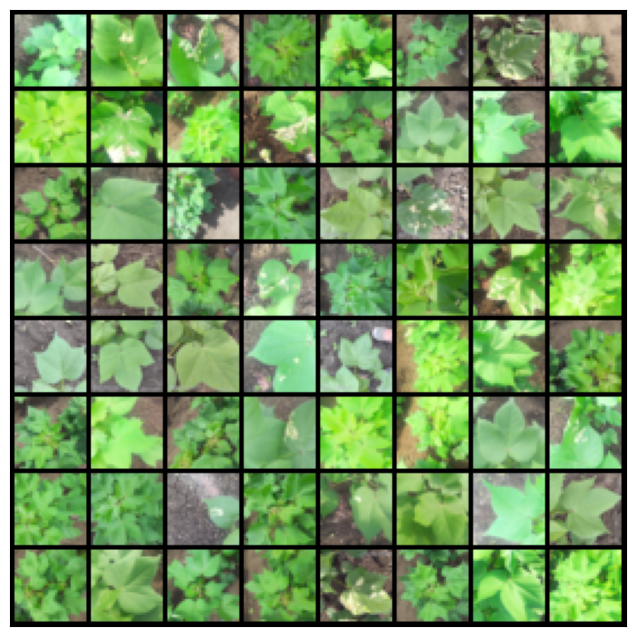

In [47]:
show_batch(train_dl)
torch.cuda.empty_cache()

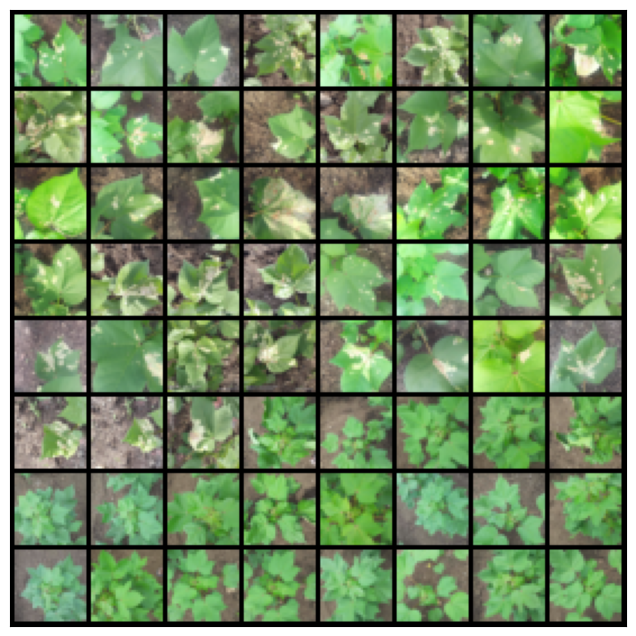

In [48]:
show_batch(val_dl)

In [49]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images) #generate Prediction
    loss = F.cross_entropy(out, labels) # calculate loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images) #generate Prediction
    loss = F.cross_entropy(out, labels) # calculate loss
    acc = accuracy(out, labels) # calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc':acc}

  def Validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() #combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean() #combine accuracy
    return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.tensor(torch.sum(preds == labels).item()/ len(preds))


In [50]:
class CnnModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1), # 3x32x32
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), # output : 64x16x16

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # 3x32x32
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), # output : 128x8x8

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # 3x32x32
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), # output : 256x4x4

        nn.Flatten(),
        nn.Linear(256*4*4, 512),
        nn.ReLU(),
        nn.Linear(512,4))
  def forward(self, xb):
    return self.network(xb)


In [51]:
model = CnnModel()
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in_features=512

In [52]:
for images, labels in train_dl:
  print('Images.shape : ',images.shape)
  out = model(images)
  print('out.shape : ', out.shape)
  print('out[0]: ', out[0])
  break


Images.shape :  torch.Size([64, 3, 32, 32])
out.shape :  torch.Size([64, 4])
out[0]:  tensor([ 0.0198,  0.0095,  0.0302, -0.0412], grad_fn=<SelectBackward0>)


In [53]:
def get_default_device():
  # "Pick GPU if available, else CPU"
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  # "Wrap a dataloader to move data to a device"
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    # Yeild a batch of data after moving it to a device
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    # Number of batches
    return len(self.dl)

In [54]:
device = get_default_device()
device

device(type='cuda')

In [55]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [88]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.Validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    #trainig phase
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    #validation phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [89]:
model = to_device(CnnModel(), device)

In [90]:
evaluate(model, val_dl)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'val_loss': 1.3857877254486084, 'val_acc': 0.3046875}

In [91]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 0.001

In [93]:
%%time
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.4081, val_loss: 0.3048, val_acc: 0.8925
Epoch [1], train_loss: 0.2264, val_loss: 0.2178, val_acc: 0.9166
Epoch [2], train_loss: 0.1895, val_loss: 0.2247, val_acc: 0.9293
Epoch [3], train_loss: 0.1563, val_loss: 0.2977, val_acc: 0.8964
Epoch [4], train_loss: 0.1540, val_loss: 0.2545, val_acc: 0.9124
Epoch [5], train_loss: 0.1360, val_loss: 0.2749, val_acc: 0.9048
Epoch [6], train_loss: 0.1209, val_loss: 0.1996, val_acc: 0.9445
Epoch [7], train_loss: 0.0991, val_loss: 0.1651, val_acc: 0.9604
CPU times: user 2.24 s, sys: 1.4 s, total: 3.64 s
Wall time: 1min 12s


In [94]:
history

[{'val_loss': 0.3047740161418915,
  'val_acc': 0.8924687504768372,
  'train_loss': 0.40807077288627625},
 {'val_loss': 0.21776679158210754,
  'val_acc': 0.9165624976158142,
  'train_loss': 0.22636635601520538},
 {'val_loss': 0.22472500801086426,
  'val_acc': 0.9293124675750732,
  'train_loss': 0.1894574910402298},
 {'val_loss': 0.2977261543273926,
  'val_acc': 0.8963750004768372,
  'train_loss': 0.15628887712955475},
 {'val_loss': 0.2545316517353058,
  'val_acc': 0.9123749732971191,
  'train_loss': 0.15404583513736725},
 {'val_loss': 0.2749442160129547,
  'val_acc': 0.9048437476158142,
  'train_loss': 0.1360211819410324},
 {'val_loss': 0.19956231117248535,
  'val_acc': 0.9444687366485596,
  'train_loss': 0.1209213137626648},
 {'val_loss': 0.16507229208946228,
  'val_acc': 0.9603750109672546,
  'train_loss': 0.09913510084152222}]

In [96]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies,)
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs no. of epochs');

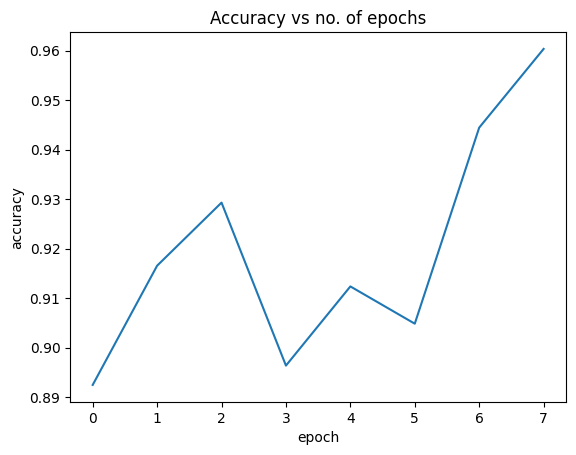

In [97]:
plot_accuracies(history)

In [98]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses)
  plt.plot(val_losses)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title("loss vs no. of epochs");

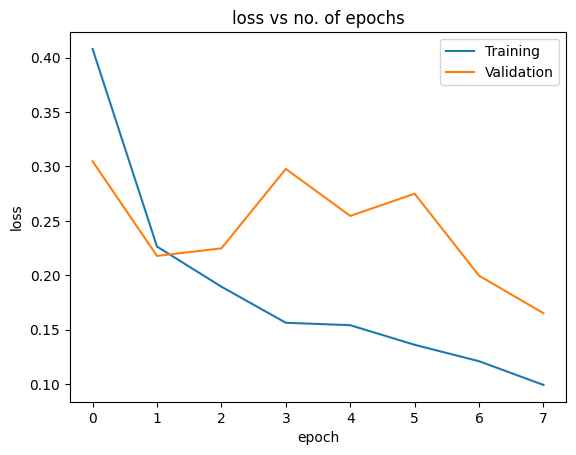

In [99]:
plot_losses(history)

In [100]:
test_dataset = ImageFolder(data_dir + '/test',transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),T.Normalize(*stats)]))

In [101]:
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim = 1)
  return dataset.classes[preds[0].item()]

In [102]:
dataset = ImageFolder(data_dir+'/train', transform =ToTensor())

In [103]:
torch.save(model.state_dict(),'ModelCotton.h5')

Label :  diseased cotton leaf Predicted :  diseased cotton leaf


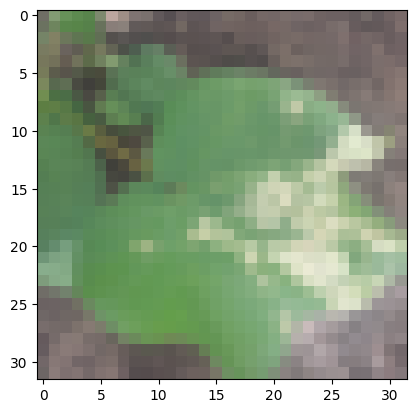

In [107]:
test_dataset1 = ImageFolder(data_dir+'/test', transform=ToTensor())
img, label = test_dataset[0]
plt.imshow(denorm(img.permute(1,2,0)))
print('Label : ',dataset.classes[label],'Predicted : ',predict_image(img,model))

In [108]:
torch.cuda.empty_cache()